In [1]:
#Based on code from: https://github.com/fubel/PyCannyEdge

# Import libraries required to do operations like convolution, gaussian blur, sobel operator, pixel manipulation, etc.
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,10)

(490, 490)


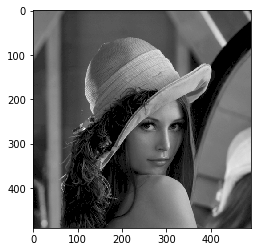

In [2]:
# Load image into variable and display it
img_gray = cv2.imread('images/lena.png', cv2.IMREAD_GRAYSCALE) 
print(img_gray.shape)
plt.imshow(img_gray, cmap='gray')
plt.show()

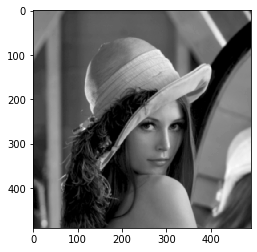

In [3]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
img_blur = cv2.GaussianBlur(img_gray,(5,5), 0) #auto-determine best sigma for kernel size 
plt.imshow(img_blur, cmap = 'gray')
plt.show()

In [4]:
# Apply Sobel Filter using the convolution operation
sobel_x = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
sobel_y = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]]) 

print("Gx=",sobel_x)
print("Gy=",sobel_y)

#Flip the kernels and perform convolution
Gx = cv2.filter2D(
        img_blur.astype(np.float), -1,
        np.flipud(np.fliplr(sobel_x)), borderType=cv2.BORDER_REFLECT)

Gy = cv2.filter2D(
        img_blur.astype(np.float), -1,
        np.flipud(np.fliplr(sobel_y)), borderType=cv2.BORDER_REFLECT)

#Normalize the gradient output between -1 and 1
Gx=Gx/Gx.max()
Gy=Gy/Gy.max()

Gx= [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
Gy= [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


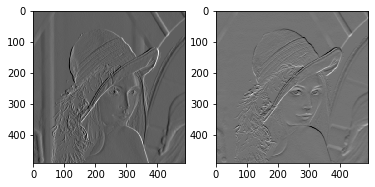

In [5]:
# Plot the derivative filter values
plt.subplot(121)
plt.imshow(Gx, cmap = 'gray')
plt.subplot(122)
plt.imshow(Gy, cmap = 'gray')
plt.show()

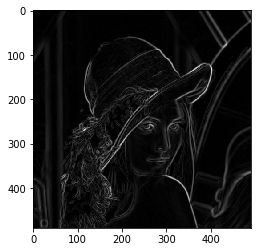

In [6]:
# Calculate the magnitude of the gradients obtained, and normalize between 0-1
mag = np.hypot(Gx,Gy)
mag /= mag.max()
plt.imshow(mag, cmap = 'gray')
plt.show()

In [7]:
# Calculate direction of the gradients and round the angles  
orientation = np.degrees(np.arctan2(Gy,Gx))
angles = np.rad2deg(orientation) % 180 #[0,180)

angles[(angles < 22.5)] = 0
angles[(angles >= 157.5) & (angles < 180)] = 0
angles[(angles >= 22.5) & (angles < 67.5)] = 45
angles[(angles >= 67.5) & (angles < 112.5)] = 90
angles[(angles >= 112.5) & (angles < 157.5)] = 135
angles = angles.astype(np.int32)
print(np.unique(angles))


[  0  45  90 135]


In [8]:
#non-maximum suppression using the closest pixel method

M, N = mag.shape
nms = np.zeros((M,N), dtype=np.float32)

for (i,j), m in np.ndenumerate(mag):
    # find neighbour pixels to visit from the gradient directions
    n = angles[i,j]
    try:
        if n == 0:
            if (m >= mag[i, j - 1]) and (m >= mag[i, j + 1]):
                nms[i,j] = m
        elif n == 90:
            if (m >= mag[i - 1, j]) and (m >= mag[i + 1, j]):
                nms[i,j] = m
        elif n == 135:
            if (m >= mag[i - 1, j - 1]) and (m >= mag[i + 1, j + 1]):
                nms[i,j] = m
        elif n == 45:
            if (m >= mag[i - 1, j + 1]) and (m >= mag[i + 1, j - 1]):
                nms[i,j] = m
    except IndexError as e: #Lazy border handling
           nms[i,j] = 0
           pass

nms /= nms.max()

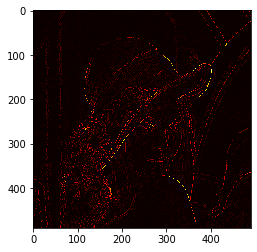

In [9]:
plt.imshow(nms, cmap='hot')
plt.show()

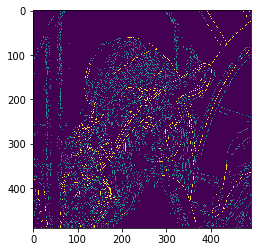

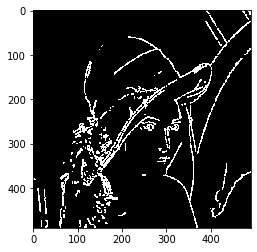

In [10]:
#Hysteresis thresholding
t2 = 0.2 
t1 = t2 * 0.15

T = np.zeros_like(nms, dtype=np.float32)
T2_i, T2_j = np.where(nms > t2)
T1_i, T1_j = np.where((nms > t1) & (nms <= t2))

#To save space, just use the same matrix for T1 and T2
T[T2_i, T2_j] = 255  #Strong edges (yellow)
T[T1_i, T1_j] = 127  #Weak edges (blue)

plt.imshow(T)
plt.show()

final = np.zeros_like(T, dtype=np.uint8)
#Perform the tracing
#This is not an efficient method, but it's good for demonstration purposes
for (i,j), _ in np.ndenumerate(T):
    if final[i,j] != 127: #Look for weak edges
        pass

    # check if one of the 9 neighbourhood is strong (which we set to 255)
    try:
        if ((T[i + 1, j] == 255) or 
            (T[i - 1, j] == 255) or 
            (T[i, j + 1] == 255) or 
            (T[i, j - 1] == 255) or 
            (T[i+1, j + 1] == 255) or 
            (T[i-1, j - 1] == 255) or
            (T[i+1,j-1] == 255) or
            (T[i-1, j+1] == 255)):
            
            final[i, j] = 255
        else:
            final[i, j] = 0
    except IndexError as e: #Again, lazy border handling
        final[i,j] = 0
        pass

plt.imshow(final, cmap = 'gray')
plt.show()


In [11]:
# Built-in Canny from opencv which should work better than this
lower = int(t1 * 255)
upper = int(t2 * 255)
edges = cv2.Canny(img_blur, lower, upper)

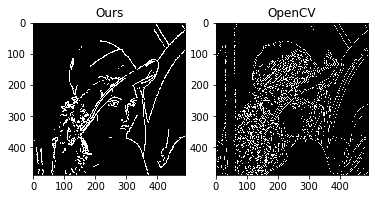

In [14]:
# Let's see how we did compared against the builtin
plt.subplot(121)
plt.title("Ours")
plt.imshow(final, cmap = 'gray')
plt.subplot(122)
plt.title("OpenCV")
plt.imshow(edges, cmap = 'gray')
plt.show()